In [1]:
import os

import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import pandas as pd
from jax import Array, random
from jax.nn import softmax
from matplotlib.figure import Figure

from gpmicrobiome import get_mcmc_summary, run_nuts

numpyro.enable_x64()

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=6"

%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format='retina'

# ruff: noqa: N803, N806

### Helper functions


In [2]:
def plot_estimates(
    X: Array,
    y: Array,
    posterior_samples: dict[str, Array],
    X_pred: Array | None = None,
    X_p: Array | None = None,
    p: Array | None = None,
    n_cols: int = 5,
) -> Figure:
    """Plot GPMicrobiome estimates.

    Args:
        X: Measurement time points.
        y: Observed counts.
        posterior_samples: Posterior samples, i.e. `mcmc.get_samples()`.
        X_pred: Prediction time points.
        X_p: Time points of true proportions, i.e. `p`.
        p: True proportions.
        n_cols: Number of columns in the figure.

    Returns:
        Matplotlib figure object.
    """
    if X_pred is not None:
        X_full = jnp.vstack((X, X_pred)).flatten()

        # posterior mean
        theta_full = jnp.vstack(
            (
                posterior_samples["theta"].mean(0),
                posterior_samples["theta_pred"].mean(0),
            )
        )

        # posterior 5th and 95th percentiles
        theta_full_5pct = jnp.vstack(
            (
                jnp.percentile(posterior_samples["theta"], 5, axis=0),
                jnp.percentile(posterior_samples["theta_pred"], 5, axis=0),
            )
        )
        theta_full_95pct = jnp.vstack(
            (
                jnp.percentile(posterior_samples["theta"], 95, axis=0),
                jnp.percentile(posterior_samples["theta_pred"], 95, axis=0),
            )
        )
    else:
        X_full = X.flatten()
        # posterior mean
        theta_full = posterior_samples["theta"].mean(0)

        # posterior 5th and 95th percentiles
        theta_full_5pct = jnp.percentile(posterior_samples["theta"], 5, axis=0)
        theta_full_95pct = jnp.percentile(posterior_samples["theta"], 95, axis=0)

    if X_p is not None and p is not None:
        assert X_p.shape[0] == p.shape[0]

    # sort
    sort_indices = jnp.argsort(X_full)
    X_full = X_full[sort_indices]
    theta_full = theta_full[sort_indices, :]
    theta_full_5pct = theta_full_5pct[sort_indices, :]
    theta_full_95pct = theta_full_95pct[sort_indices, :]

    fig = plt.figure()
    n_rows = jnp.ceil(y.shape[1] / n_cols)
    fig.set_size_inches(3 * n_cols, 2 * n_rows)

    for idx in range(y.shape[1]):
        ax = fig.add_subplot(int(n_rows), n_cols, idx + 1)
        ax.plot(X_full, theta_full[:, idx], lw=2, c=f"C{idx}", label="Mean")
        ax.fill_between(
            X_full,
            theta_full_5pct[:, idx],
            theta_full_95pct[:, idx],
            alpha=0.2,
            fc=f"C{idx}",
            label="90% CI",
        )

        if X_p is not None and p is not None:
            ax.plot(X_p.flatten(), p[:, idx], ls="--", lw=2, c=f"C{idx}", label="True")

        ax.scatter(
            X.flatten(),
            (y / jnp.sum(y, 1, keepdims=True))[:, idx],
            s=5,
            marker=".",
            c=f"C{idx}",
            label="MLE",
        )

        ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

        if idx == 0:
            ax.legend(fontsize=7)

    fig.set_tight_layout(True)

    return fig


def se(x1: Array, x2: Array, alpha: Array, length: Array) -> Array:
    """Squared exponential.

    Args:
        x1: First input.
        x2: Second input.
        alpha: Signal magnitude parameter.
        length: Length-scale parameter.

    Returns:
        Covariance matrix.
    """
    return alpha * jnp.exp(-0.5 * jnp.square(x1[:, None] - x2) / jnp.square(length))

## Example 1: No missing timepoints


### Generate data


In [3]:
# number of measurement time points
num_timepoints = 30
# number of OTUs
num_otus = 10
# mean total count per time point
total_count = 10_000
# probability of sampling zero
p_sampling_zero = 0.05
alpha = 2
length = 10
sigma = 0.5

X = jnp.arange(num_timepoints)[:, None]

key = random.PRNGKey(0)
key, key_ = random.split(key, 2)
# OTU proportions
p_real = random.multivariate_normal(
    key_,
    jnp.zeros(X.shape[0]),
    se(X[:, 0], X[:, 0], alpha, length) + 1e-4 * jnp.eye(X.shape[0]),
    (num_otus,),
)
p = softmax(p_real.T)
key, key_ = random.split(key, 2)
p_noisy = softmax((p_real + sigma * random.normal(key_, p_real.shape)).T)
key, key_ = random.split(key, 2)

# total count per timepoint
num_obs_per_timepoint = dist.NegativeBinomialProbs(
    total_count * (1 - 0.99), 0.99
).sample(key_, sample_shape=(num_timepoints,))
key, key_ = random.split(key, 2)

# count per time point per OTU
y = dist.MultinomialProbs(
    probs=p_noisy,
    total_count=num_obs_per_timepoint,
    total_count_max=int(jnp.max(num_obs_per_timepoint)),
).sample(key_)
key, key_ = random.split(key, 2)

# introduce sampling zeros
sampling_zeros = random.bernoulli(key_, 1 - p_sampling_zero, (num_timepoints, num_otus))
y_sampling_zeros = y * sampling_zeros

### Run inference


In [4]:
key, key_ = random.split(key, 2)
mcmc = run_nuts(
    key_, X, y_sampling_zeros, num_warmup=1_000, num_samples=1_000, num_chains=4
)

posterior_samples = mcmc.get_samples()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

### Ensure convergence


In [5]:
mcmc_summary_df = get_mcmc_summary(mcmc)
mcmc_summary_df.query("r_hat > 1.05")

,variable,index,mean,std,median,5.0%,95.0%,n_eff,r_hat


### Plot estimates


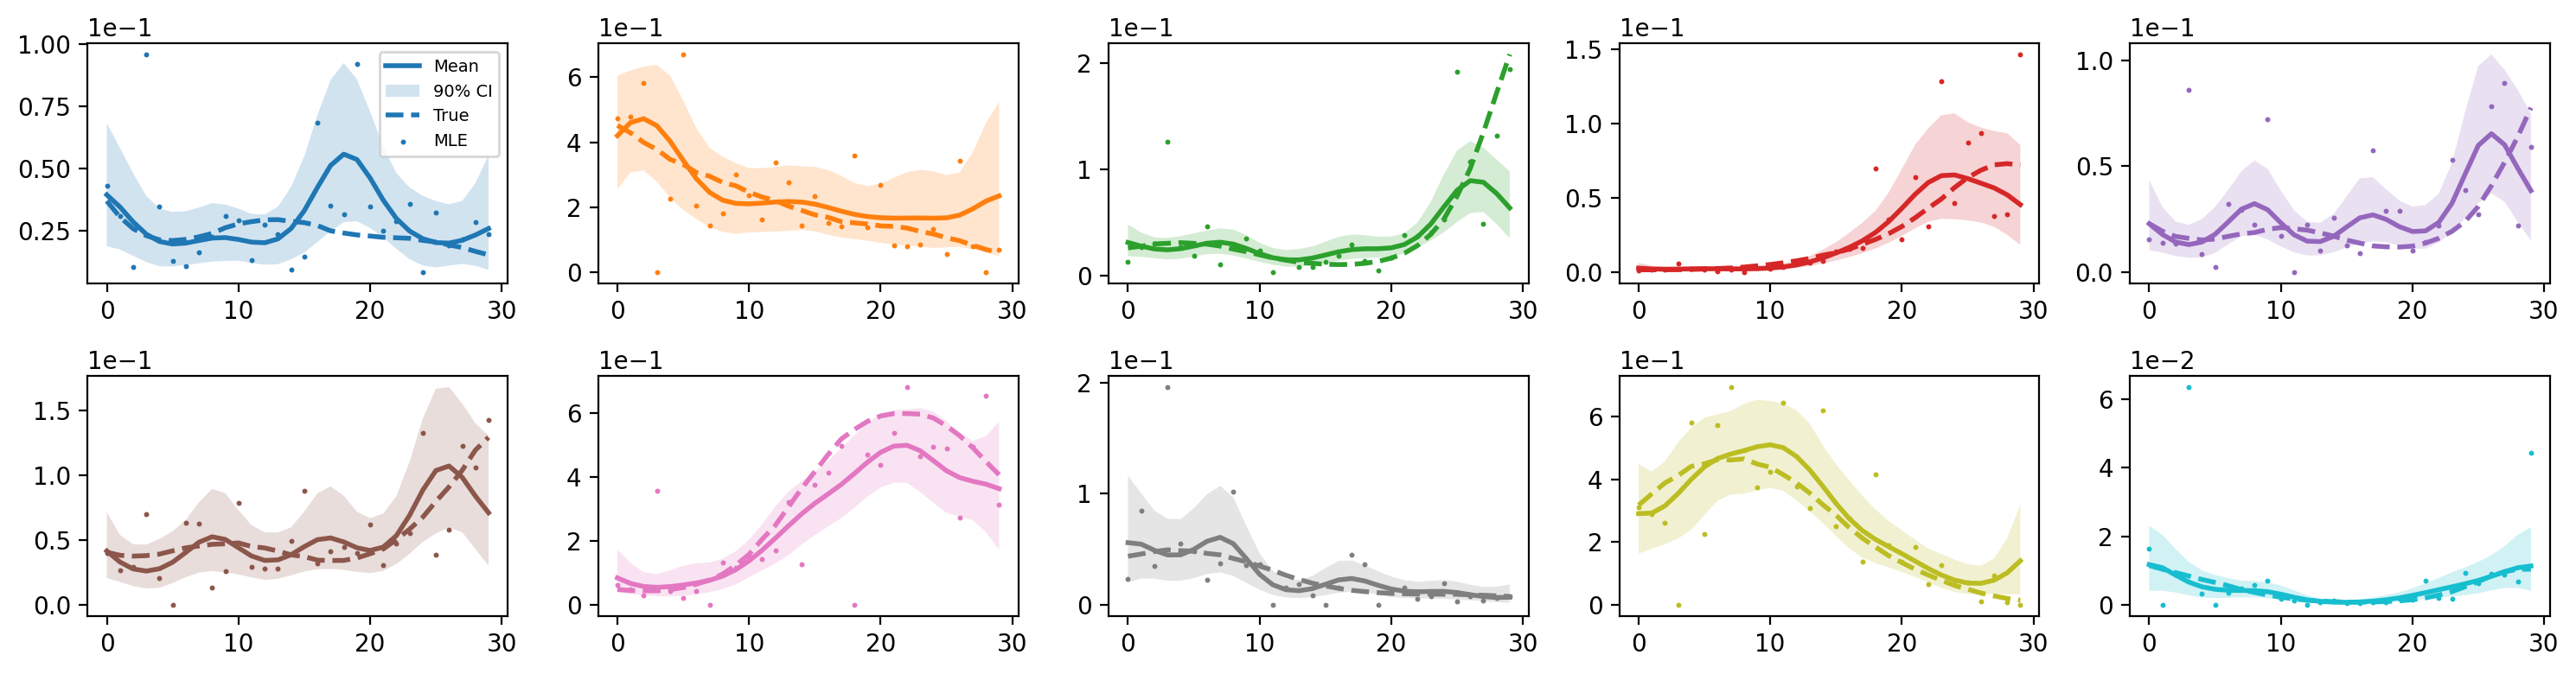

In [6]:
plot_estimates(X, y_sampling_zeros, posterior_samples, X_p=X, p=p);

## Example 2: missing timepoints


### Generate data


In [7]:
# number of measurement time points
num_timepoints = 30
# number of prediction time points
num_pred_timepoints = 5
# number of OTUs
num_otus = 10
# mean total count per time point
total_count = 10_000
# probability of sampling zero
p_sampling_zero = 0.05
alpha = 2
length = 10
sigma = 0.5

# lack of measurements from 15 to 15 + num_pred_timepoints
X = jnp.vstack(
    (
        jnp.arange(15)[:, None],
        jnp.arange(15 + num_pred_timepoints, num_timepoints + num_pred_timepoints)[
            :, None
        ],
    )
)
# predict for time points from 15 to 15 + num_pred_timepoints
X_pred = jnp.arange(15, 15 + num_pred_timepoints)[:, None]

key = random.PRNGKey(0)
key, key_ = random.split(key, 2)
# OTU proportions
X_p = jnp.sort(jnp.vstack((X, X_pred)), axis=0)
p_real = random.multivariate_normal(
    key_,
    jnp.zeros(X_p.shape[0]),
    se(X_p[:, 0], X_p[:, 0], alpha, length) + 1e-4 * jnp.eye(X_p.shape[0]),
    (num_otus,),
)
p = softmax(p_real.T)
key, key_ = random.split(key, 2)
indices = jnp.asarray([jnp.where(X_p == x)[0][0] for x in X])
p_noisy = softmax(
    (p_real[:, indices] + sigma * random.normal(key_, p_real[:, indices].shape)).T
)
key, key_ = random.split(key, 2)

# total count per timepoint
num_obs_per_timepoint = dist.NegativeBinomialProbs(
    total_count * (1 - 0.99), 0.99
).sample(key_, sample_shape=(num_timepoints,))
key, key_ = random.split(key, 2)

# count per time point per OTU
y = dist.MultinomialProbs(
    probs=p_noisy,
    total_count=num_obs_per_timepoint,
    total_count_max=int(jnp.max(num_obs_per_timepoint)),
).sample(key_)
key, key_ = random.split(key, 2)

# introduce sampling zeros
sampling_zeros = random.bernoulli(key_, 1 - p_sampling_zero, (num_timepoints, num_otus))
y_sampling_zeros = y * sampling_zeros

### Run inference


In [8]:
key, key_ = random.split(key, 2)
mcmc = run_nuts(
    key_, X, y_sampling_zeros, X_pred, num_warmup=1_000, num_samples=1_000, num_chains=4
)

posterior_samples = mcmc.get_samples()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

### Ensure convergence


In [9]:
mcmc_summary_df = get_mcmc_summary(mcmc)
mcmc_summary_df.query("r_hat > 1.05")

,variable,index,mean,std,median,5.0%,95.0%,n_eff,r_hat


### Plot estimates


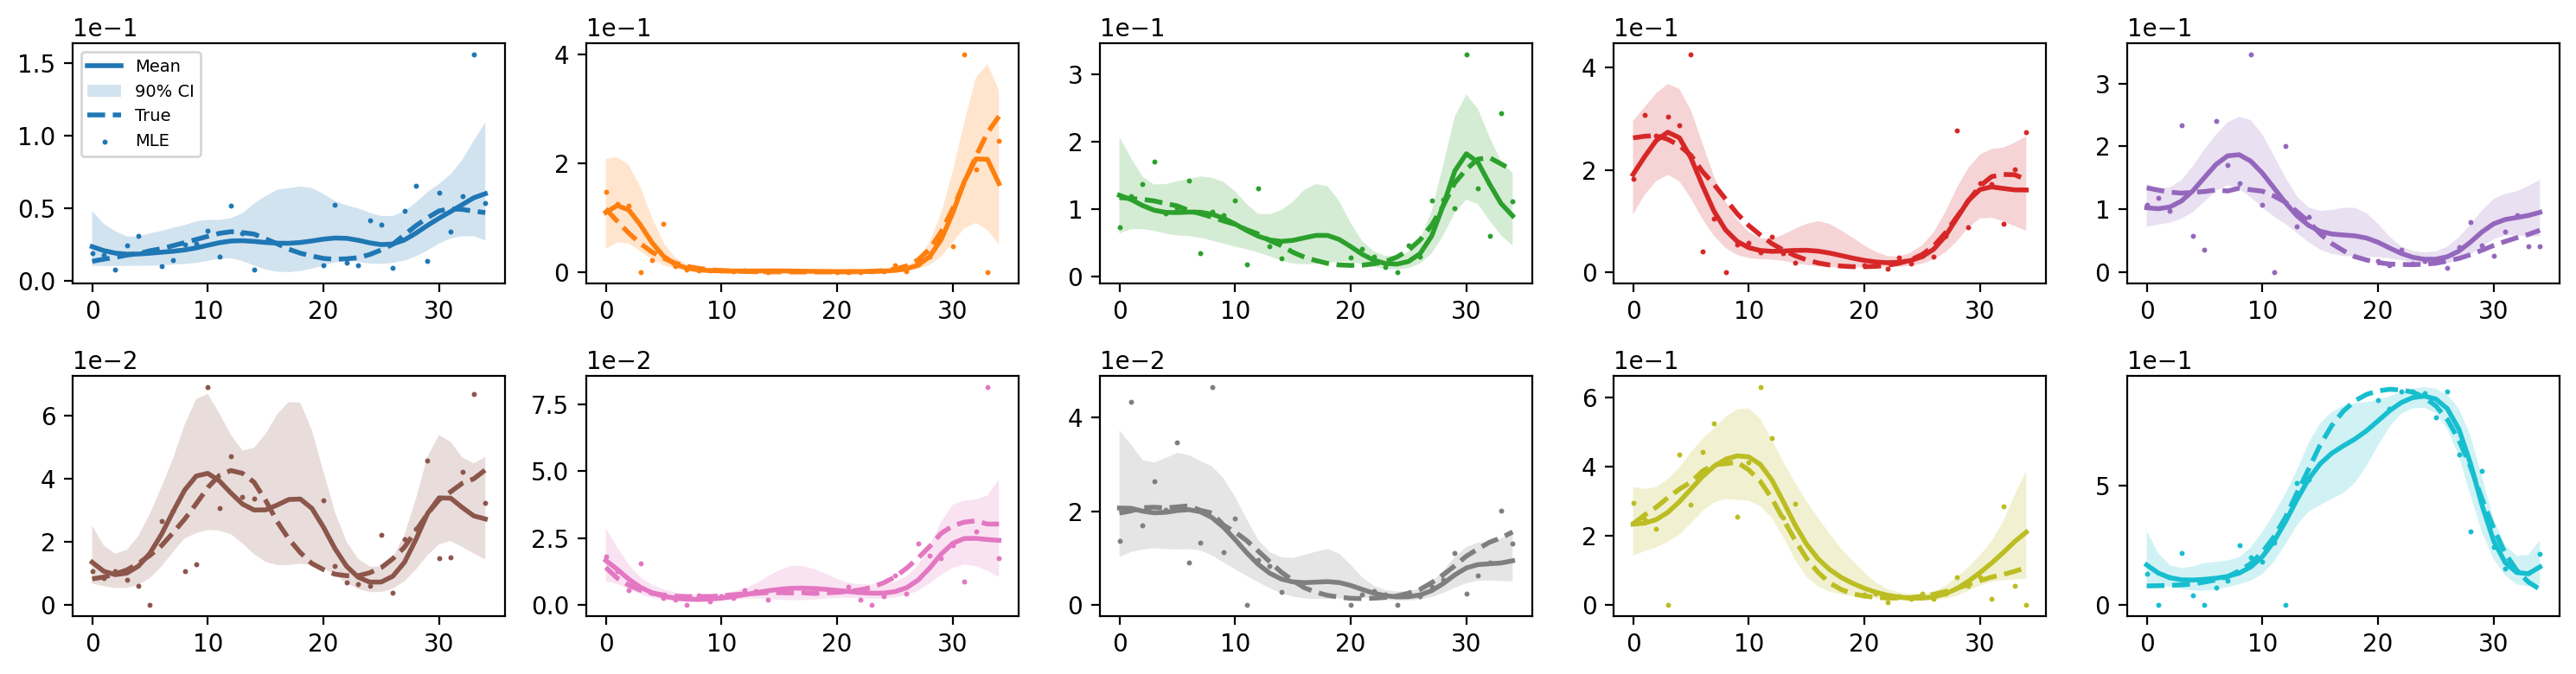

In [10]:
plot_estimates(X, y_sampling_zeros, posterior_samples, X_pred, X_p, p);

## Example 3: read data from file


In [11]:
data_df = pd.read_csv("toy_data.tsv", sep="\t")

X = data_df[["x"]].to_numpy()
y = data_df[[col for col in data_df.columns if col != "x"]].to_numpy()

### Run inference


In [12]:
key = random.PRNGKey(0)
key, key_ = random.split(key, 2)
mcmc = run_nuts(key_, X, y, num_warmup=1_000, num_samples=1_000, num_chains=4)

posterior_samples = mcmc.get_samples()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

### Ensure convergence


In [13]:
mcmc_summary_df = get_mcmc_summary(mcmc)
mcmc_summary_df.query("r_hat > 1.05")

,variable,index,mean,std,median,5.0%,95.0%,n_eff,r_hat


### Plot estimates


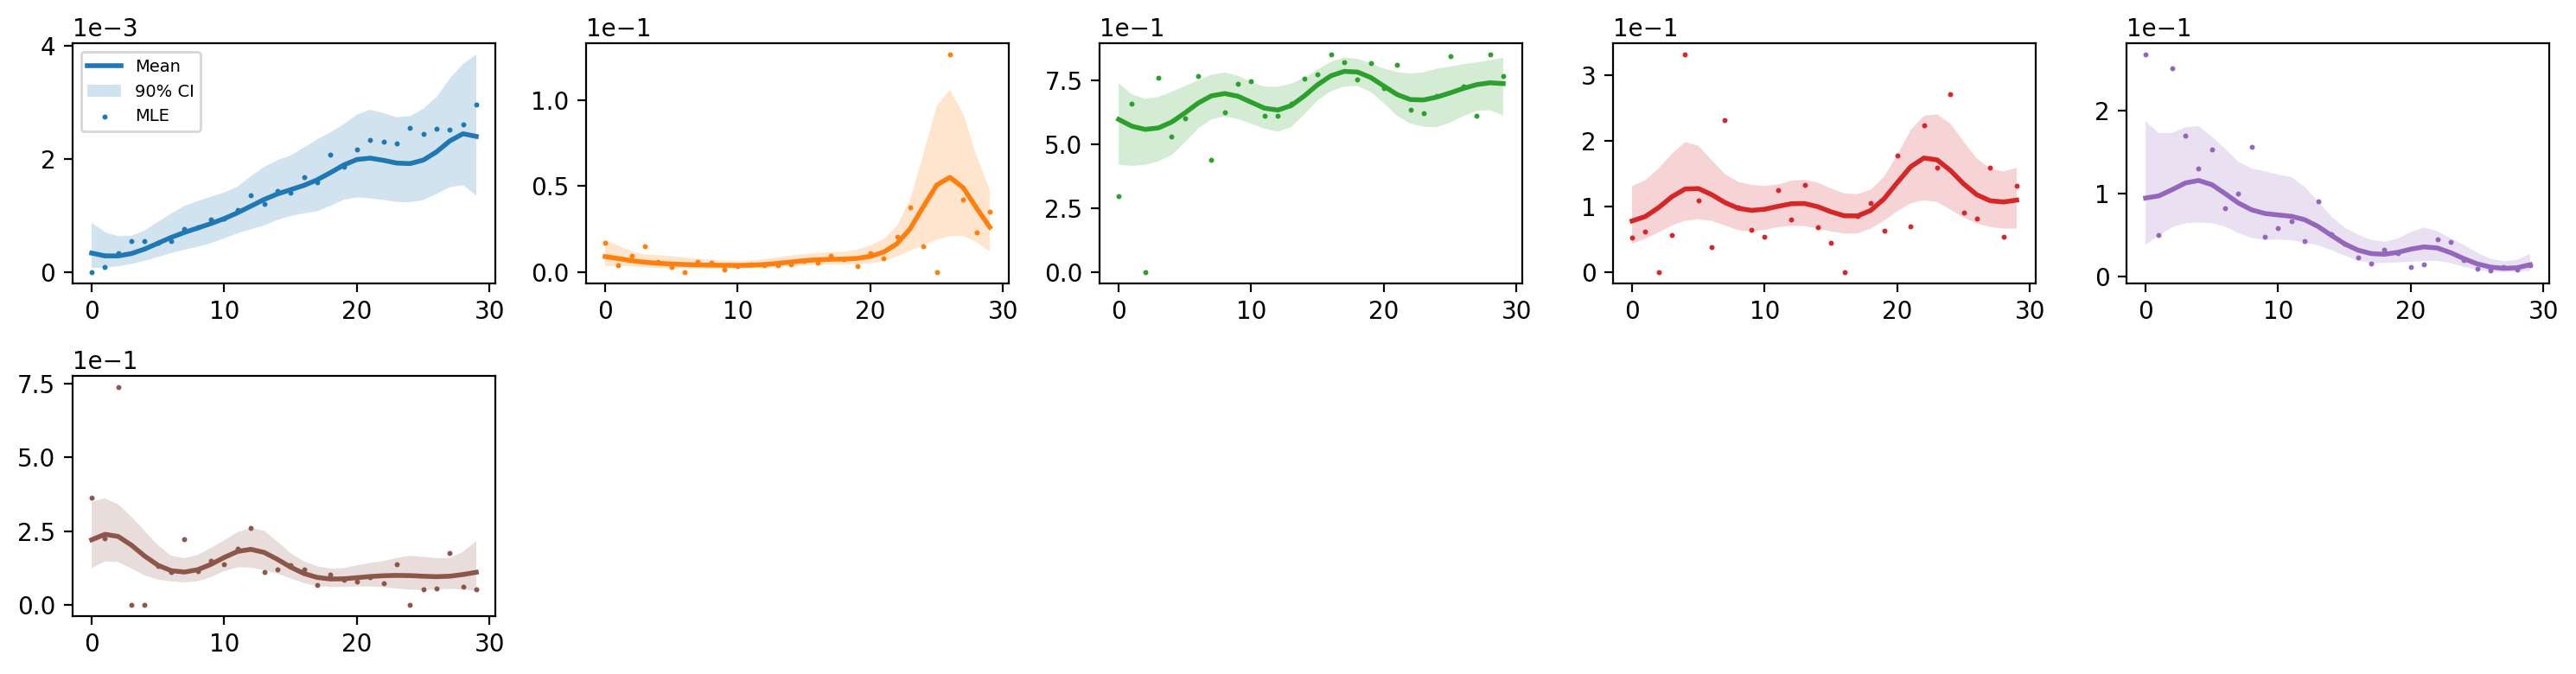

In [14]:
plot_estimates(X, y, posterior_samples);